In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("Librerías cargadas correctamente")

Librerías cargadas correctamente


In [2]:
# Cargar datos desde MongoDB
from pymongo import MongoClient
from dotenv import load_dotenv
import os

load_dotenv()

MONGO_URI = os.getenv('MONGO_URI')
DB_NAME = os.getenv('DB_NAME')

print("Conectando a MongoDB Atlas...")
client = MongoClient(MONGO_URI)
db = client[DB_NAME]
collection = db['monthly_sales']

# Obtener todos los documentos
data = list(collection.find())
df = pd.DataFrame(data)

print(f"✓ Datos cargados: {len(df):,} registros")
print(f"✓ Columnas: {df.columns.tolist()}")

client.close()

Conectando a MongoDB Atlas...
✓ Datos cargados: 61,249 registros
✓ Columnas: ['_id', 'product_id', 'category', 'year', 'month', 'orders_count', 'total_sales', 'avg_freight', 'product_weight', 'product_photos']


In [3]:
# Eliminar columna _id (no es útil para predicción)
df = df.drop('_id', axis=1)

# Verificar valores nulos
print("Valores nulos por columna:")
print(df.isnull().sum())

# Estadísticas básicas
print("\nEstadísticas descriptivas:")
print(df.describe())

# Información del dataset
print(f"\nShape del dataset: {df.shape}")
print(f"Tipos de datos:\n{df.dtypes}")

Valores nulos por columna:
product_id        0
category          0
year              0
month             0
orders_count      0
total_sales       0
avg_freight       0
product_weight    0
product_photos    0
dtype: int64

Estadísticas descriptivas:
              year         month  orders_count   total_sales   avg_freight  \
count  61249.00000  61249.000000  61249.000000  61249.000000  61249.000000   
mean    2017.52938      6.092997      1.812634    218.855164     20.723137   
std        0.50812      3.183987      2.779503    471.708831     16.999028   
min     2016.00000      1.000000      1.000000      2.200000      0.000000   
25%     2017.00000      3.000000      1.000000     49.900000     13.460000   
50%     2018.00000      6.000000      1.000000     99.980000     16.530000   
75%     2018.00000      8.000000      2.000000    208.000000     21.590000   
max     2018.00000     12.000000    122.000000  29899.390000    409.680000   

       product_weight  product_photos  
count    

In [4]:
# Codificar categorías
le = LabelEncoder()
df['category_encoded'] = le.fit_transform(df['category'])

# Crear feature de fecha (para capturar tendencia temporal)
df['date_numeric'] = df['year'] * 12 + df['month']

# Crear lag features (ventas del mes anterior)
df_sorted = df.sort_values(['product_id', 'year', 'month'])
df_sorted['sales_lag_1'] = df_sorted.groupby('product_id')['total_sales'].shift(1)
df_sorted['sales_lag_2'] = df_sorted.groupby('product_id')['total_sales'].shift(2)

# Eliminar filas con valores nulos (lag features)
df_sorted = df_sorted.dropna()

print(f"Dataset después de crear features: {df_sorted.shape}")
print(f"Registros con features completos: {len(df_sorted):,}")

Dataset después de crear features: (17215, 13)
Registros con features completos: 17,215


In [5]:
# Definir features (X) y target (y)
feature_columns = [
    'category_encoded', 
    'year', 
    'month', 
    'orders_count',
    'avg_freight', 
    'product_weight', 
    'product_photos',
    'date_numeric',
    'sales_lag_1',
    'sales_lag_2'
]

X = df_sorted[feature_columns]
y = df_sorted['total_sales']

print(f"Features (X): {X.shape}")
print(f"Target (y): {y.shape}")
print(f"\nColumnas features:\n{feature_columns}")

# División de datos: 70% train, 15% validation, 15% test
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.176, random_state=42)

print(f"\n✓ Train set: {X_train.shape[0]:,} registros")
print(f"✓ Validation set: {X_val.shape[0]:,} registros")
print(f"✓ Test set: {X_test.shape[0]:,} registros")

Features (X): (17215, 10)
Target (y): (17215,)

Columnas features:
['category_encoded', 'year', 'month', 'orders_count', 'avg_freight', 'product_weight', 'product_photos', 'date_numeric', 'sales_lag_1', 'sales_lag_2']

✓ Train set: 12,056 registros
✓ Validation set: 2,576 registros
✓ Test set: 2,583 registros


In [6]:
# Normalizar datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print("✓ Datos normalizados")
print(f"Media de features escalados: {X_train_scaled.mean():.4f}")
print(f"Desviación estándar: {X_train_scaled.std():.4f}")

✓ Datos normalizados
Media de features escalados: 0.0000
Desviación estándar: 1.0000


In [7]:
from sklearn.ensemble import RandomForestRegressor
import time

print("="*60)
print("MODELO 1: RANDOM FOREST")
print("="*60)

# Entrenar Random Forest
start_time = time.time()

rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)

training_time_rf = time.time() - start_time

# Predicciones
y_train_pred_rf = rf_model.predict(X_train)
y_val_pred_rf = rf_model.predict(X_val)
y_test_pred_rf = rf_model.predict(X_test)

# Métricas
train_rmse_rf = np.sqrt(mean_squared_error(y_train, y_train_pred_rf))
val_rmse_rf = np.sqrt(mean_squared_error(y_val, y_val_pred_rf))
test_rmse_rf = np.sqrt(mean_squared_error(y_test, y_test_pred_rf))

train_r2_rf = r2_score(y_train, y_train_pred_rf)
val_r2_rf = r2_score(y_val, y_val_pred_rf)
test_r2_rf = r2_score(y_test, y_test_pred_rf)

print(f"\n✓ Entrenamiento completado en {training_time_rf:.2f} segundos")
print(f"\nMétricas Random Forest:")
print(f"  Train RMSE: ${train_rmse_rf:.2f} | R²: {train_r2_rf:.4f}")
print(f"  Val RMSE:   ${val_rmse_rf:.2f} | R²: {val_r2_rf:.4f}")
print(f"  Test RMSE:  ${test_rmse_rf:.2f} | R²: {test_r2_rf:.4f}")

MODELO 1: RANDOM FOREST

✓ Entrenamiento completado en 0.62 segundos

Métricas Random Forest:
  Train RMSE: $162.60 | R²: 0.9242
  Val RMSE:   $409.75 | R²: 0.6400
  Test RMSE:  $275.47 | R²: 0.7711


In [8]:
from sklearn.ensemble import GradientBoostingRegressor

print("="*60)
print("MODELO 2: GRADIENT BOOSTING")
print("="*60)

# Entrenar Gradient Boosting
start_time = time.time()

gb_model = GradientBoostingRegressor(
    n_estimators=100,
    max_depth=7,
    learning_rate=0.1,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42
)

gb_model.fit(X_train, y_train)

training_time_gb = time.time() - start_time

# Predicciones
y_train_pred_gb = gb_model.predict(X_train)
y_val_pred_gb = gb_model.predict(X_val)
y_test_pred_gb = gb_model.predict(X_test)

# Métricas
train_rmse_gb = np.sqrt(mean_squared_error(y_train, y_train_pred_gb))
val_rmse_gb = np.sqrt(mean_squared_error(y_val, y_val_pred_gb))
test_rmse_gb = np.sqrt(mean_squared_error(y_test, y_test_pred_gb))

train_r2_gb = r2_score(y_train, y_train_pred_gb)
val_r2_gb = r2_score(y_val, y_val_pred_gb)
test_r2_gb = r2_score(y_test, y_test_pred_gb)

print(f"\n✓ Entrenamiento completado en {training_time_gb:.2f} segundos")
print(f"\nMétricas Gradient Boosting:")
print(f"  Train RMSE: ${train_rmse_gb:.2f} | R²: {train_r2_gb:.4f}")
print(f"  Val RMSE:   ${val_rmse_gb:.2f} | R²: {val_r2_gb:.4f}")
print(f"  Test RMSE:  ${test_rmse_gb:.2f} | R²: {test_r2_gb:.4f}")

MODELO 2: GRADIENT BOOSTING

✓ Entrenamiento completado en 2.31 segundos

Métricas Gradient Boosting:
  Train RMSE: $89.50 | R²: 0.9770
  Val RMSE:   $410.60 | R²: 0.6385
  Test RMSE:  $255.40 | R²: 0.8033


In [9]:
from sklearn.neural_network import MLPRegressor

print("="*60)
print("MODELO 3: RED NEURONAL FEEDFORWARD (MLPRegressor)")
print("="*60)

start_time = time.time()

# Arquitectura: 128 -> 64 -> 32 -> 16 -> 1
nn_model = MLPRegressor(
    hidden_layer_sizes=(128, 64, 32, 16),
    activation='relu',
    solver='adam',
    learning_rate_init=0.001,
    max_iter=300,
    early_stopping=True,
    validation_fraction=0.15,
    n_iter_no_change=20,
    random_state=42,
    verbose=True
)

print("\nArquitectura de la Red Neuronal:")
print("  Input Layer: 10 features")
print("  Hidden Layer 1: 128 neurons (ReLU)")
print("  Hidden Layer 2: 64 neurons (ReLU)")
print("  Hidden Layer 3: 32 neurons (ReLU)")
print("  Hidden Layer 4: 16 neurons (ReLU)")
print("  Output Layer: 1 neuron")
print(f"  Optimizer: Adam (learning_rate=0.001)")
print(f"  Early Stopping: Enabled")

print("\nEntrenando...")
nn_model.fit(X_train_scaled, y_train)

training_time_nn = time.time() - start_time

# Predicciones
y_train_pred_nn = nn_model.predict(X_train_scaled)
y_val_pred_nn = nn_model.predict(X_val_scaled)
y_test_pred_nn = nn_model.predict(X_test_scaled)

# Métricas
train_rmse_nn = np.sqrt(mean_squared_error(y_train, y_train_pred_nn))
val_rmse_nn = np.sqrt(mean_squared_error(y_val, y_val_pred_nn))
test_rmse_nn = np.sqrt(mean_squared_error(y_test, y_test_pred_nn))

train_r2_nn = r2_score(y_train, y_train_pred_nn)
val_r2_nn = r2_score(y_val, y_val_pred_nn)
test_r2_nn = r2_score(y_test, y_test_pred_nn)

print(f"\n✓ Entrenamiento completado en {training_time_nn:.2f} segundos")
print(f"\nMétricas Red Neuronal:")
print(f"  Train RMSE: ${train_rmse_nn:.2f} | R²: {train_r2_nn:.4f}")
print(f"  Val RMSE:   ${val_rmse_nn:.2f} | R²: {val_r2_nn:.4f}")
print(f"  Test RMSE:  ${test_rmse_nn:.2f} | R²: {test_r2_nn:.4f}")

MODELO 3: RED NEURONAL FEEDFORWARD (MLPRegressor)

Arquitectura de la Red Neuronal:
  Input Layer: 10 features
  Hidden Layer 1: 128 neurons (ReLU)
  Hidden Layer 2: 64 neurons (ReLU)
  Hidden Layer 3: 32 neurons (ReLU)
  Hidden Layer 4: 16 neurons (ReLU)
  Output Layer: 1 neuron
  Optimizer: Adam (learning_rate=0.001)
  Early Stopping: Enabled

Entrenando...
Iteration 1, loss = 204538.91481055
Validation score: -0.126167
Iteration 2, loss = 135354.15516755
Validation score: 0.586456
Iteration 3, loss = 66963.82922977
Validation score: 0.688246
Iteration 4, loss = 59823.89620315
Validation score: 0.692713
Iteration 5, loss = 57975.54082710
Validation score: 0.700088
Iteration 6, loss = 57456.12025200
Validation score: 0.708352
Iteration 7, loss = 57277.10696330
Validation score: 0.710488
Iteration 8, loss = 56229.38109303
Validation score: 0.710670
Iteration 9, loss = 56176.35910461
Validation score: 0.714554
Iteration 10, loss = 56911.54405209
Validation score: 0.714091
Iteration 11, 

In [10]:
# Tabla comparativa de modelos
print("="*80)
print("COMPARACIÓN DE MODELOS")
print("="*80)

models_comparison = pd.DataFrame({
    'Model': ['Random Forest', 'Gradient Boosting', 'Neural Network'],
    'Train RMSE': [train_rmse_rf, train_rmse_gb, train_rmse_nn],
    'Val RMSE': [val_rmse_rf, val_rmse_gb, val_rmse_nn],
    'Test RMSE': [test_rmse_rf, test_rmse_gb, test_rmse_nn],
    'Train R²': [train_r2_rf, train_r2_gb, train_r2_nn],
    'Val R²': [val_r2_rf, val_r2_gb, val_r2_nn],
    'Test R²': [test_r2_rf, test_r2_gb, test_r2_nn],
    'Training Time (s)': [training_time_rf, training_time_gb, training_time_nn]
})

print(models_comparison.to_string(index=False))

# Identificar mejor modelo
best_model_idx = models_comparison['Test R²'].idxmax()
best_model_name = models_comparison.loc[best_model_idx, 'Model']

print(f"\n{'='*80}")
print(f"MEJOR MODELO: {best_model_name}")
print(f"Test R²: {models_comparison.loc[best_model_idx, 'Test R²']:.4f}")
print(f"Test RMSE: ${models_comparison.loc[best_model_idx, 'Test RMSE']:.2f}")
print(f"{'='*80}")

COMPARACIÓN DE MODELOS
            Model  Train RMSE   Val RMSE  Test RMSE  Train R²   Val R²  Test R²  Training Time (s)
    Random Forest  162.597963 409.747588 275.468842  0.924177 0.640028 0.771111           0.616943
Gradient Boosting   89.500181 410.602617 255.396629  0.977027 0.638525 0.803252           2.314560
   Neural Network  305.966230 417.606532 280.752041  0.731518 0.626088 0.762247           1.297015

MEJOR MODELO: Gradient Boosting
Test R²: 0.8033
Test RMSE: $255.40


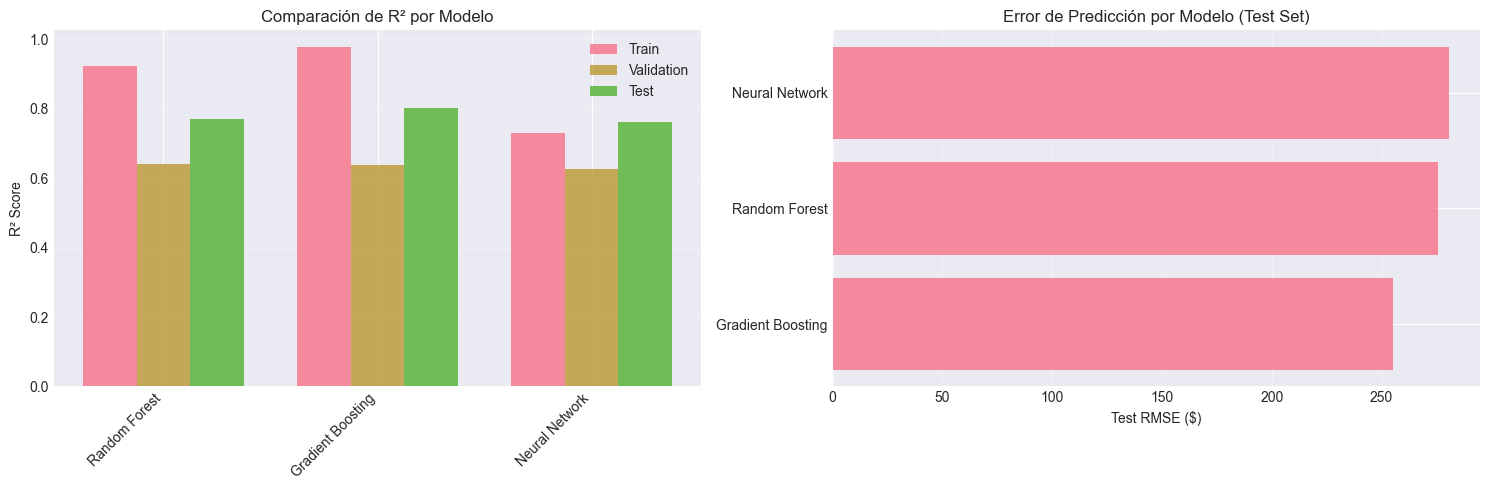

✓ Gráfica guardada en: models/model_comparison.png


In [11]:
# Visualización 1: Comparación de R² por conjunto de datos
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# R² Score por modelo
models = ['Random Forest', 'Gradient Boosting', 'Neural Network']
train_r2 = [train_r2_rf, train_r2_gb, train_r2_nn]
val_r2 = [val_r2_rf, val_r2_gb, val_r2_nn]
test_r2 = [test_r2_rf, test_r2_gb, test_r2_nn]

x = np.arange(len(models))
width = 0.25

axes[0].bar(x - width, train_r2, width, label='Train', alpha=0.8)
axes[0].bar(x, val_r2, width, label='Validation', alpha=0.8)
axes[0].bar(x + width, test_r2, width, label='Test', alpha=0.8)
axes[0].set_ylabel('R² Score')
axes[0].set_title('Comparación de R² por Modelo')
axes[0].set_xticks(x)
axes[0].set_xticklabels(models, rotation=45, ha='right')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# RMSE por modelo
rmse_data = models_comparison[['Model', 'Test RMSE']].sort_values('Test RMSE')
axes[1].barh(rmse_data['Model'], rmse_data['Test RMSE'], alpha=0.8)
axes[1].set_xlabel('Test RMSE ($)')
axes[1].set_title('Error de Predicción por Modelo (Test Set)')
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('../models/model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Gráfica guardada en: models/model_comparison.png")

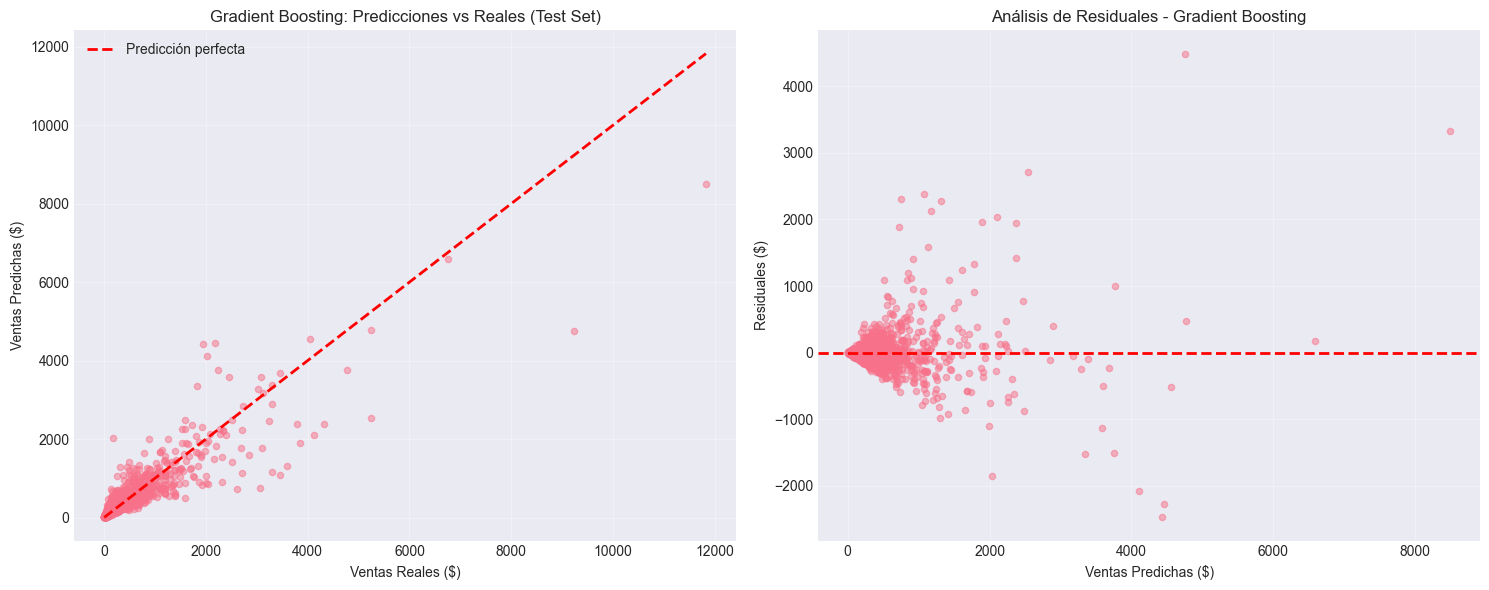

✓ Gráfica guardada en: models/predictions_analysis.png


In [12]:
# Visualización 2: Predicciones vs Valores Reales (Gradient Boosting)
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Scatter plot
axes[0].scatter(y_test, y_test_pred_gb, alpha=0.5, s=20)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
             'r--', lw=2, label='Predicción perfecta')
axes[0].set_xlabel('Ventas Reales ($)')
axes[0].set_ylabel('Ventas Predichas ($)')
axes[0].set_title('Gradient Boosting: Predicciones vs Reales (Test Set)')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Residuales
residuals = y_test - y_test_pred_gb
axes[1].scatter(y_test_pred_gb, residuals, alpha=0.5, s=20)
axes[1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[1].set_xlabel('Ventas Predichas ($)')
axes[1].set_ylabel('Residuales ($)')
axes[1].set_title('Análisis de Residuales - Gradient Boosting')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../models/predictions_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Gráfica guardada en: models/predictions_analysis.png")

In [ ]:
import joblib

# Guardar modelos
joblib.dump(rf_model, '../models/random_forest_model.pkl')
joblib.dump(gb_model, '../models/gradient_boosting_model.pkl')
joblib.dump(nn_model, '../models/neural_network_model.pkl')
joblib.dump(scaler, '../models/scaler.pkl')

# Guardar también el label encoder de categorías
joblib.dump(le, '../models/label_encoder.pkl')

print("✓ Modelos guardados exitosamente:")
print("  - random_forest_model.pkl")
print("  - gradient_boosting_model.pkl")
print("  - neural_network_model.pkl")
print("  - scaler.pkl")
print("  - label_encoder.pkl")

✓ Modelos guardados exitosamente:
  - random_forest_model.pkl
  - gradient_boosting_model.pkl
  - neural_network_model.pkl
  - scaler.pkl
  - label_encoder.pkl
